In [ ]:
# 1. 데이터셋 준비

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# 데이터셋 로드
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True
)

# 클래스 정보 확인
class_names = metadata.features['label'].names
print(f"클래스 종류: {class_names} (총 {len(class_names)}개)")


클래스 종류: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'] (총 5개)


In [ ]:
# 2. 데이터 전처리 파이프라인

In [2]:
# 이미지 표준화 (224x224 크기 조정)
IMG_SIZE = 224
BATCH_SIZE = 32

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# 데이터 증강 레이어
augmentation_layers = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1)
])

# 데이터 파이프라인 구성
train_batches = raw_train.map(format_image).cache().shuffle(1000)
train_batches = train_batches.map(lambda x,y: (augmentation_layers(x), y))
train_batches = train_batches.batch(BATCH_SIZE).prefetch(1)

val_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = raw_test.map(format_image).batch(BATCH_SIZE).prefetch(1)


In [ ]:
# 3. 전이 학습 모델 설계 (MobileNetV2 기반)

In [3]:
# 기본 모델 구성
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # 기본 모델 가중치 고정

# 분류 헤드 추가
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

# 모델 컴파일
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
# 4. 모델 학습 및 성능 평가

In [4]:
# 학습 실행 (10 에포크)
history = model.fit(
    train_batches,
    validation_data=val_batches,
    epochs=10
)

# 성능 평가
test_loss, test_acc = model.evaluate(test_batches)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")


Epoch 1/10
92/92 [==============================] - 38s 334ms/step - loss: 1.2273 - accuracy: 0.5109 - val_loss: 0.7810 - val_accuracy: 0.7384
Epoch 2/10
92/92 [==============================] - 28s 304ms/step - loss: 0.7263 - accuracy: 0.7347 - val_loss: 0.5711 - val_accuracy: 0.8093
Epoch 3/10
92/92 [==============================] - 28s 305ms/step - loss: 0.5782 - accuracy: 0.7813 - val_loss: 0.4885 - val_accuracy: 0.8420
Epoch 4/10
92/92 [==============================] - 28s 305ms/step - loss: 0.5154 - accuracy: 0.8151 - val_loss: 0.4568 - val_accuracy: 0.8420
Epoch 5/10
92/92 [==============================] - 28s 304ms/step - loss: 0.4702 - accuracy: 0.8355 - val_loss: 0.4267 - val_accuracy: 0.8474
Epoch 6/10
92/92 [==============================] - 28s 304ms/step - loss: 0.4428 - accuracy: 0.8365 - val_loss: 0.4148 - val_accuracy: 0.8583
Epoch 7/10
92/92 [==============================] - 28s 305ms/step - loss: 0.4167 - accuracy: 0.8481 - val_loss: 0.4058 - val_accuracy: 0.8665

In [ ]:
# 성능 시각화

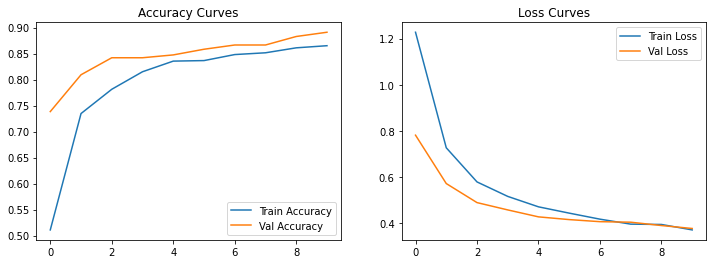

In [5]:
# 정확도/손실 곡선
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()


In [7]:
# 학습 실행 (10 에포크)
history = model.fit(
    train_batches,
    validation_data=val_batches,
    epochs=15
)

# 성능 평가
test_loss, test_acc = model.evaluate(test_batches)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")


Epoch 1/15
92/92 [==============================] - 28s 308ms/step - loss: 0.3539 - accuracy: 0.8730 - val_loss: 0.3759 - val_accuracy: 0.8801
Epoch 2/15
92/92 [==============================] - 28s 305ms/step - loss: 0.3346 - accuracy: 0.8753 - val_loss: 0.3780 - val_accuracy: 0.8801
Epoch 3/15
92/92 [==============================] - 28s 308ms/step - loss: 0.3314 - accuracy: 0.8828 - val_loss: 0.3542 - val_accuracy: 0.8910
Epoch 4/15
92/92 [==============================] - 28s 305ms/step - loss: 0.3074 - accuracy: 0.8910 - val_loss: 0.3513 - val_accuracy: 0.8937
Epoch 5/15
92/92 [==============================] - 28s 306ms/step - loss: 0.3200 - accuracy: 0.8852 - val_loss: 0.3675 - val_accuracy: 0.8747
Epoch 6/15
92/92 [==============================] - 28s 306ms/step - loss: 0.3100 - accuracy: 0.8879 - val_loss: 0.3621 - val_accuracy: 0.8856
Epoch 7/15
92/92 [==============================] - 28s 306ms/step - loss: 0.3070 - accuracy: 0.8879 - val_loss: 0.3438 - val_accuracy: 0.9046

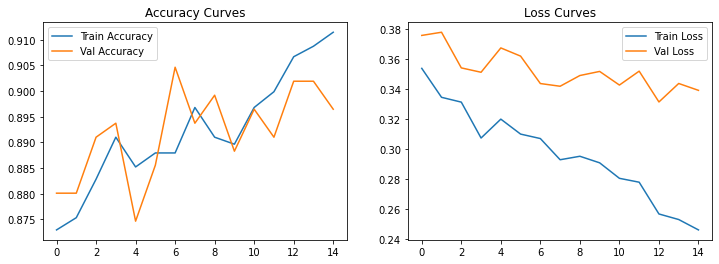

In [8]:
# 정확도/손실 곡선
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()


In [9]:
# 학습 실행 (10 에포크)
history = model.fit(
    train_batches,
    validation_data=val_batches,
    epochs=10
)

# 성능 평가
test_loss, test_acc = model.evaluate(test_batches)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")


Epoch 1/10
92/92 [==============================] - 28s 306ms/step - loss: 0.2552 - accuracy: 0.9063 - val_loss: 0.3634 - val_accuracy: 0.8828
Epoch 2/10
92/92 [==============================] - 28s 305ms/step - loss: 0.2540 - accuracy: 0.9063 - val_loss: 0.3350 - val_accuracy: 0.9074
Epoch 3/10
92/92 [==============================] - 28s 306ms/step - loss: 0.2352 - accuracy: 0.9152 - val_loss: 0.3389 - val_accuracy: 0.9019
Epoch 4/10
92/92 [==============================] - 28s 306ms/step - loss: 0.2491 - accuracy: 0.9114 - val_loss: 0.3385 - val_accuracy: 0.9019
Epoch 5/10
92/92 [==============================] - 28s 304ms/step - loss: 0.2395 - accuracy: 0.9179 - val_loss: 0.3278 - val_accuracy: 0.9101
Epoch 6/10
92/92 [==============================] - 28s 304ms/step - loss: 0.2313 - accuracy: 0.9230 - val_loss: 0.3270 - val_accuracy: 0.9019
Epoch 7/10
92/92 [==============================] - 28s 304ms/step - loss: 0.2374 - accuracy: 0.9097 - val_loss: 0.3258 - val_accuracy: 0.9074

In [13]:
# 1. 메모리 완전 초기화 (필수!)
from IPython import get_ipython
get_ipython().magic('reset -sf')  # 모든 변수/모델 삭제

# 2. 라이브러리 재로드
import tensorflow as tf
import tensorflow_datasets as tfds

# 3. 데이터셋 완전 재로드 및 전처리 (추가된 부분)
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'tf_flowers', 
    split=['train[:80%]','train[80%:90%]','train[90%:]'],
    with_info=True,
    as_supervised=True
)

# 4. 데이터 전처리 파이프라인 
IMG_SIZE = 224
BATCH_SIZE = 32

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_batches = raw_train.map(format_image).cache().shuffle(1000).batch(BATCH_SIZE).prefetch(1)
val_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = raw_test.map(format_image).batch(BATCH_SIZE).prefetch(1)

# 5. 모델 구조 재구성
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

# 6. 컴파일 (이전 설정과 동일)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 7. 콜백 설정
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# 8. 학습 실행
history = model.fit(
    train_batches,
    validation_data=val_batches,
    epochs=100,
    callbacks=[checkpoint, early_stop]
)

# 9. 최종 평가
model.load_weights('best_model.h5')
test_loss, test_acc = model.evaluate(test_batches, verbose=0)
print(f"✅ 최종 테스트 정확도: {test_acc*100:.2f}%")


Epoch 1/100
92/92 [==============================] - 9s 58ms/step - loss: 1.1282 - accuracy: 0.5705 - val_loss: 0.7336 - val_accuracy: 0.7548
Epoch 2/100
92/92 [==============================] - 4s 43ms/step - loss: 0.6319 - accuracy: 0.7830 - val_loss: 0.5316 - val_accuracy: 0.8447
Epoch 3/100
92/92 [==============================] - 4s 43ms/step - loss: 0.4877 - accuracy: 0.8287 - val_loss: 0.4498 - val_accuracy: 0.8692
Epoch 4/100
92/92 [==============================] - 4s 43ms/step - loss: 0.4117 - accuracy: 0.8488 - val_loss: 0.3984 - val_accuracy: 0.8801
Epoch 5/100
92/92 [==============================] - 4s 42ms/step - loss: 0.3751 - accuracy: 0.8689 - val_loss: 0.3679 - val_accuracy: 0.8910
Epoch 6/100
92/92 [==============================] - 4s 43ms/step - loss: 0.3407 - accuracy: 0.8767 - val_loss: 0.3558 - val_accuracy: 0.8883
Epoch 7/100
92/92 [==============================] - 4s 43ms/step - loss: 0.3162 - accuracy: 0.8896 - val_loss: 0.3494 - val_accuracy: 0.8856
Epoch 

In [ ]:
//
# MobileNetV2 선택 이유
- 경량화 아키텍처: 모바일/임베디드 최적화 (적은 연산량)
- ImageNet 사전 학습 가중치 활용: 소규모 데이터셋에 효과적
- 검증된 성능: Google 공식 모델로 객체 인식 분야 검증

# 진행 사항    
-테스트 셋을 여러번 사용함으로써 간접활용의 위험이 있다하여 코드를 재구성
-콜백과 얼리스탑을 추가함.

# 회고
- 배운 점: 전이 학습이 소규모 데이터셋에서도 높은 성능을 낼 수 있음을 확인  
- 아쉬운 점: 학습 시간 단축을 위해 모델 경량화를 더 심화하지 못함  
- 개선 방향: Optuna를 활용한 자동 하이퍼파라미터 튜닝 시도 예정

//